In [1]:
import numpy as np
import xarray as xr
import sys
sys.path.append('../')
from xdispersion import RelativeDispersion
from xdispersion import rel_disp
import matplotlib.cm as cm
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd

#Save figure or not
save = True

# List of dataset paths
files = [
    './data/ExpA/fort.3001.np4000nt6000.nc',
    './data/ExpB/fort.1001.np4000nt5993.nc',
    './data/ExpN/fort.1001.np4000nt6000.nc',
    './data/ExpO/fort.1001.np4000nt6000.nc'
]

# Open all datasets into a list
drifters_list = [xr.open_dataset(f) for f in files]

lvc_list = [] #lagrangian velocity correlation
rrms_list= [] #rms separation
rzrr_list = [] #ratio zonal to radial separation

for i,ds in enumerate(drifters_list):
    drifters = drifters_list[i]
    rd = RelativeDispersion(drifters, ragged=False, ID='tracer',
                        xpos='x', uvel='ux', time='time',
                        ypos='y', vvel='uy', coord='polar')
    pairs = rd.get_all_pairs()
    origin_pairs = rd.get_original_pairs(pairs, r0=[0.005, 0.01])
    rx, ry, rxy, r, rpb = rd.separation_measures(origin_pairs) # separations of different components
    du, dv, dul, dut, vmi, vmj, uv = rd.velocity_measures(origin_pairs) # velocities of different components
    
    r2   = rel_disp(r, order=2, mean_at='const-t') #pair separation 
    r2x   = rel_disp(rx, order=2, mean_at='const-t') #radial
    r2y   = rel_disp(ry, order=2, mean_at='const-t') #zonal (arclength)

    rrms = np.sqrt(r2) #rms separation
    rrms_list.append(rrms)
    rzrr_list.append(r2y/r2x)

    #Lagrangian velocity correlation
    vmim =(vmi**2).mean('pair') #vmi is velocity magnitude of particle i.
    vmjm =(vmj**2).mean('pair') #vmj velocity magnitude of particle j.
    uvm  =  uv.mean('pair') #uv is inner product of two particle's velocities
    lvc = 2.0 *uvm /(vmim + vmjm) 
    lvc_list.append(lvc)

#lvc_list


/home/dgsl1/miniforge3/envs/xdispersion/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:818: RuntimeWarning: invalid value encountered in arccos
  result_data = func(*input_data)


/tmp/ipykernel_8826/2400163854.py:32: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[0].set_xlim([0, 300])
/tmp/ipykernel_8826/2400163854.py:41: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  axes[1].set_xlim([0, 0.5])


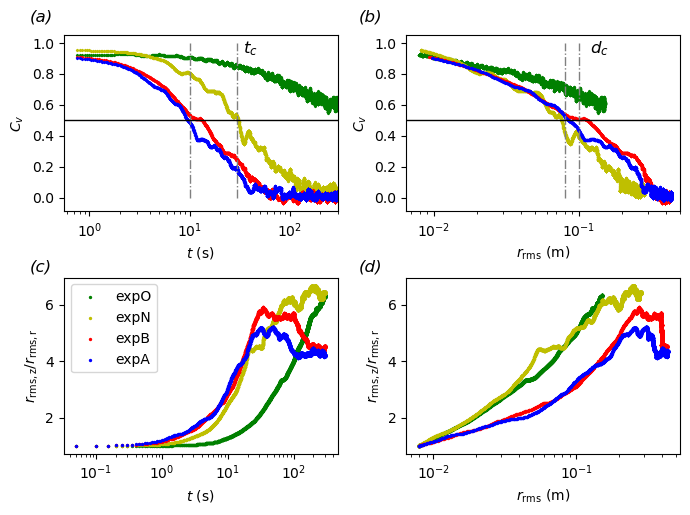

In [4]:
import matplotlib.pyplot as plt

#plt.rcParams["font.family"] = "sans-serif"
#plt.rcParams["mathtext.fontset"] = "cm"   # Computer Modern (LaTeX-style serif)

colors = plt.cm.magma(np.linspace(0, 1, len(lvc_list)+2))
colors = ['b','r','y','g']
exp_labels = ["expA", "expB", "expN", "expO"]

lvc_smooth_list = [ds.rolling(rtime=30, center=True).mean() for ds in lvc_list]

fig, axes = plt.subplots(2, 2, figsize=(7, 5))  # (rows, cols)
axes = axes.flatten()  # flatten 2D array -> 1D list of axes

for i, (rzrr, lvc, rrms, c, label) in enumerate(zip(
    rzrr_list[::-1], lvc_smooth_list[::-1], rrms_list[::-1], colors[::-1], exp_labels[::-1]), start=1):
    # Left subplot: LVC (lagrangian velocity corelation) vs time
    axes[0].scatter(lvc.rtime, lvc.values, marker='x', s=2, color=c, label=label)
    # Right subplot: LVC vs rms separation
    axes[1].scatter(rrms, lvc.values, marker='x', s=2, color=c, label=label)
    # Bottom left: zonal over radial dispersion versus time
    axes[2].scatter(rzrr.rtime,np.sqrt(rzrr),s=2,color=c,label=label)
    # Same versus rms separation
    axes[3].scatter(rrms,np.sqrt(rzrr),s=2,color=c,label=label)

axes[0].set_xscale('log')
axes[0].set_xlabel(r"$t$ (s)")
axes[0].set_ylabel(r'$C_v$')
axes[0].plot([10, 10], [0, 1], '-.', color='gray',linewidth=1)
axes[0].plot([30, 30], [0, 1], '-.', color='gray',linewidth=1)
axes[0].plot([0, 300], [0.5, 0.5], '-', color='k',linewidth=1)
axes[0].set_xlim([0, 300])
axes[0].text(34, 0.9, r"$t_c$", ha='left', va='bottom', fontsize=12)

axes[1].set_xscale('log')
axes[1].set_xlabel(r"$r_{\rm rms}$ (m)")
axes[1].set_ylabel(r'$C_v$')
axes[1].plot([0.1, 0.1], [0, 1], '-.', color='gray',linewidth=1)
axes[1].plot([0.08, 0.08], [0, 1], '-.', color='gray',linewidth=1)
axes[1].plot([0, 0.5], [0.5, 0.5], '-', color='k',linewidth=1)
axes[1].set_xlim([0, 0.5])
axes[1].text(0.12, 0.9, r"$d_c$", ha='left', va='bottom', fontsize=12)


axes[3].set_ylabel(r"$ r_{\rm rms,z} / r_{\rm rms,r}$")
axes[3].set_xlabel(r"$r_{\rm rms}$ (m)")
axes[3].set_xscale('log')
#axes[1].set_yscale('log')

#axes[2].plot([10, 10], [0, 7], '-.', color='gray')
#axes[2].plot([30, 30], [0, 7], '-.', color='gray')
axes[2].set_ylabel(r"$ r_{\rm rms,z} / r_{\rm rms,r}$")
axes[2].set_xlabel(r"$t$ (s)")
axes[2].set_xscale('log')
#axes[2].set_yscale('log')

axes[2].legend(loc='upper left')

panel_labels = ['(a)', '(b)', '(c)', '(d)']
positions = [
    (0.05, 1.02),  # (a) top-left subplot
    (0.52, 1.02),  # (b) top-right subplot
    (0.05, 0.52),  # (c) bottom-left subplot
    (0.52, 0.52)   # (d) bottom-right subplot
]

for label, (x, y) in zip(panel_labels, positions):
    fig.text(x, y, label, ha='left', va='top',
             fontsize=12,fontstyle='italic')

save=True
plt.tight_layout()
if save:
    output_path = f"../paper_daphne/correlation_isotropy.pdf"
    fig.savefig(output_path, format='pdf', bbox_inches='tight')  # save as PDF
plt.show()


